# <center> Работа с геоданными
<center> Глазунов А.В.

Монтируем диск (работаем с Google Colab)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Меняем рабочую директорию

In [2]:
cd /content/gdrive/'My Drive'/Colab_Notebooks/ML_c6_TAXI

/content/gdrive/My Drive/Colab_Notebooks/ML_c6_TAXI


Устанавливаем недостающие модули

In [14]:
%%time
!pip install --upgrade geopandas
!pip install --upgrade contextily

Requirement already up-to-date: geopandas in /usr/local/lib/python3.6/dist-packages (0.7.0)
Requirement already up-to-date: contextily in /usr/local/lib/python3.6/dist-packages (1.0.0)
CPU times: user 46.8 ms, sys: 19.5 ms, total: 66.3 ms
Wall time: 9.7 s


Импортируем библиотеки

In [0]:
import os
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from shapely.geometry import Polygon
import geopandas
import contextily as ctx
import folium

import warnings
warnings.filterwarnings("ignore")



Путь к файлам

In [0]:
path = 'week2'

Загружаем данные

In [6]:
regions = pd.read_csv(os.path.join(path,'regions.csv'),sep=';')
regions.head()

region      west       east      south      north
0       1 -74.25559 -74.244478  40.496120  40.504508
1       2 -74.25559 -74.244478  40.504508  40.512896
2       3 -74.25559 -74.244478  40.512896  40.521285
3       4 -74.25559 -74.244478  40.521285  40.529673
4       5 -74.25559 -74.244478  40.529673  40.538061

In [7]:
counts = pd.read_csv(os.path.join(path,'time_series_table.csv'),sep=',',index_col=0)
counts.head()

1  2  3  4  5  6  ...  2495  2496  2497  2498  2499  2500
2016-05-01 00:00:00  0  0  0  0  0  0  ...     0     0     0     0     0     0
2016-05-01 01:00:00  0  0  0  0  0  0  ...     0     0     0     0     0     0
2016-05-01 02:00:00  0  0  0  0  0  0  ...     0     0     0     0     0     0
2016-05-01 03:00:00  0  0  0  0  0  0  ...     0     0     0     0     0     0
2016-05-01 04:00:00  0  0  0  0  0  0  ...     0     0     0     0     0     0

[5 rows x 2500 columns]

Подсчитаем общее количество поездок из каждой зоны и среднее количество поездок в час за май 2016 

In [0]:
overall_counts = pd.DataFrame(counts.sum(),columns=['count'])
mean_counts = pd.DataFrame(counts.mean(),columns=['count'])

Количество зон, откуда не было поездок в мае 2016 

In [25]:
sum(overall_counts['count']==0)

1283

Функции для построения карт

In [0]:
def static_map_NY(counts,regions):
  
  """
  Строит статическую карту Нью-Йорка, 
  на которую наносит heatmap столбца counts по зонам regions
  и отмечает Empire State Building (40.748817, -73.985428))
  На вход:
  - датафрейм с частотами, из одного столбца count,
  - сетка регионов,
  - координаты точки
  """

  #Сетка со значениями
  polygons = []
  for region in regions.values:
  
    polygons.append(Polygon([(region[1],region[4]), (region[2], region[4]),\
                           (region[2], region[3]), (region[1], region[3])]))  

  grid = geopandas.GeoDataFrame(counts,geometry = polygons,crs = 4326)
  grid = grid.to_crs(epsg=3857)

  #Строим карту
  df = geopandas.read_file(geopandas.datasets.get_path('nybb'))
  df = df.to_crs(epsg=3857)
  ax = df.plot(figsize=(30,15), alpha=0.5, edgecolor='k')
  ctx.add_basemap(ax,url=ctx.providers.Stamen.TonerLite)

  #Heatmap
  grid.plot(ax=ax,column='count',cmap='gist_heat_r',alpha=0.5,edgecolor='grey',legend=True)

  #Отмечаем точку
  point=[-73.985428,40.748817]
  Point = geopandas.GeoDataFrame(geometry=geopandas.points_from_xy([point[0]],[point[1]]),crs = 4326)
  Point = Point.to_crs(epsg=3857)
  Point.plot(marker = '*',ax=ax, color = 'red', label = 'Empire State Building',markersize=200)
  ax.legend()

  ax.set_axis_off();

In [0]:
def dynamic_map_NY(counts,regions,criteria = 5, save=False):
  """
  - Строит динамическую карту Нью-Йорка
  - Строит heatmap по counts (df со столбцом count)
  - Отмечает Статую Свободы и Empire State Building
  - Помещает на карту маркеры для зон с count>criteria

  Можно управлять отображением слоев
  """

  #добавляем столбец ID в counts для Choropleth
  counts['id'] = range(1,regions.shape[0]+1)

  #Сетка
  geo_json = {"type": "FeatureCollection",
            "features":[]}

  for region in regions.values:
    
    coords = [[region[1],region[4]],
              [region[2],region[4]],
              [region[2],region[3]],
              [region[1],region[3]]]    

    grid_feature = {
                "type":"Feature",
                "id":region[0],
                 "geometry":{
                          "type":"Polygon",
                          "coordinates": [coords],
                          }                   
                   }
            
    geo_json["features"].append(grid_feature)

  
  #Выделяем ячейки с количеством count > creteria
  good_cells = counts[counts['count']>criteria]
  good_cells_id = np.array(good_cells.index,dtype=int)
  good_indices = [id - 1 for id in good_cells_id]
  regions_good = regions.iloc[good_indices]
  
  #Центры ячеек для размещения маркеров
  regions_good['mid_long']=regions_good.apply(lambda row: (row['east']+row['west'])/2,  axis=1)
  regions_good['mid_lat']=regions_good.apply(lambda row: (row['north']+row['south'])/2,  axis=1)

  #КАРТА
  m = folium.Map(location=[40.748817,-73.985428,], zoom_start=10.5)

  #слой достопримечательностей
  sites = folium.map.FeatureGroup(name='Places')
  place1= [40.689047, -74.044569]
  place2 = [40.748817,-73.985428]
  sites.add_children(folium.Marker([place1[0], place1[1]], popup='<i>Statue of Liberty</i>',tooltip = 'Click me!'))
  sites.add_children(folium.Marker([place2[0], place2[1]], popup='<i>Empire State Building</i>',tooltip = 'Click me!'))
  sites.add_to(m)

  #слой города
  ny = geopandas.read_file(geopandas.datasets.get_path('nybb'))

  folium.Choropleth(
    geo_data=ny,
    name='ny', 
    fill_opacity=0.2,
    line_opacity=0.2,     
  ).add_to(m)

  #слой heatmap по counts
  folium.Choropleth(
    geo_data=geo_json,
    name='Mean taxi count',
    data=counts,
    columns=['id','count'],
    key_on='feature.id',
    fill_color='Reds',
    fill_opacity=0.6,
    line_opacity=0.2,
    legend_name='Taxi count'    
  ).add_to(m)

  #слой маркеров зон с большим count
  taxi_markers = folium.map.FeatureGroup(name='Taxi markers')

  for row in regions_good.values:
    id = int(row[0])  
    count = counts['count'][id-1]
    message = f'<i>Id: {id}, Count: {round(count,1)}</i>'
    coords = [row[-1],row[-2]]
    taxi_markers.add_children(folium.Marker(coords,
                                          popup=message,
                                          icon=folium.Icon(icon='taxi',color='orange',prefix='fa')
                                          )     
                            ) 
  taxi_markers.add_to(m)


  folium.LayerControl().add_to(m)
  
  #сохраняем карту
  if save:
    m.save("TAXI.html")

  #рисуем в ноутбуке
  display(m) 

Строим статическую карту


CPU times: user 2.2 s, sys: 357 ms, total: 2.56 s
Wall time: 2.2 s


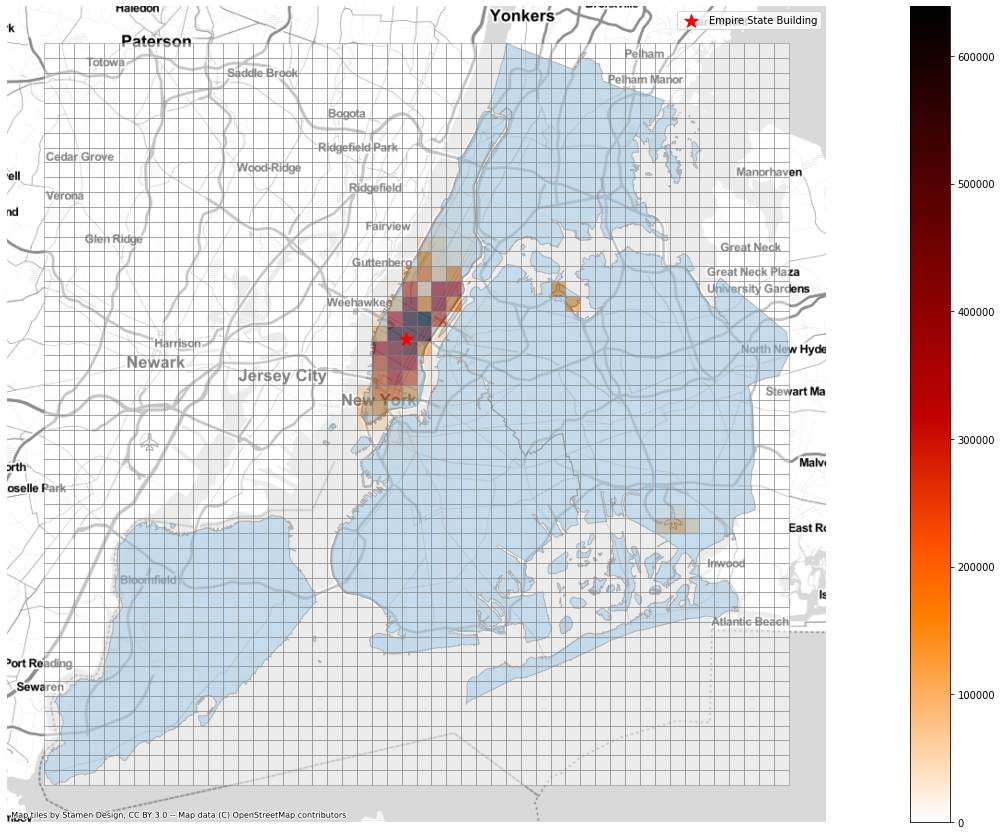

In [15]:
%%time
static_map_NY(overall_counts,regions)

Строим динамическую карту

In [24]:
%%time
dynamic_map_NY(mean_counts,regions, save=False)

CPU times: user 1.57 s, sys: 22.5 ms, total: 1.59 s
Wall time: 1.6 s


Количество зон, где среднее число поездок в час больше 5

In [22]:
sum(mean_counts['count']>5)

102

Анализируя карту, из выбранных ячеек не видно ни одной, расположенной в недосигаемом для автомобиля месте.